In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'GDX'  # gold
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_gdx.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4643, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2006-05-22,36.520000,37.290001,35.869999,37.230000,32.197544,3.471890,1.019441,1.019608,1.013967
2006-05-23,37.750000,39.220001,37.750000,37.959999,32.828876,3.491309,1.005563,0.962065,0.978135
2006-05-24,37.130001,37.570000,35.869999,36.520000,31.583519,3.452635,0.983571,1.049288,1.018072
2006-05-25,37.180000,38.320000,36.980000,38.320000,33.140205,3.500747,1.030662,1.006002,1.010960
2006-05-26,38.740002,38.740002,37.770000,38.549999,33.339123,3.506732,0.995095,0.990143,1.024643
2006-05-30,39.500000,39.720001,38.110001,38.169998,33.010487,3.496825,0.966329,1.017815,1.019125
2006-05-31,38.900002,39.130001,38.119999,38.849998,33.598560,3.514483,0.998715,0.991764,0.957529
2006-06-01,37.200001,38.580002,37.169998,38.529999,33.321827,3.506213,1.035753,1.015572,1.020244
2006-06-02,39.310001,39.389999,38.799999,39.130001,33.840729,3.521665,0.995421,0.974444,1.029134


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2006-05-22    37.290001
2006-05-23    39.220001
2006-05-24    37.570000
2006-05-25    38.320000
2006-05-26    38.740002
                ...    
2024-10-24    43.509998
2024-10-25    42.160000
2024-10-28    41.630001
2024-10-29    42.130001
2024-10-30    41.939999
Name: high, Length: 4643, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2008-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2008-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

4643

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

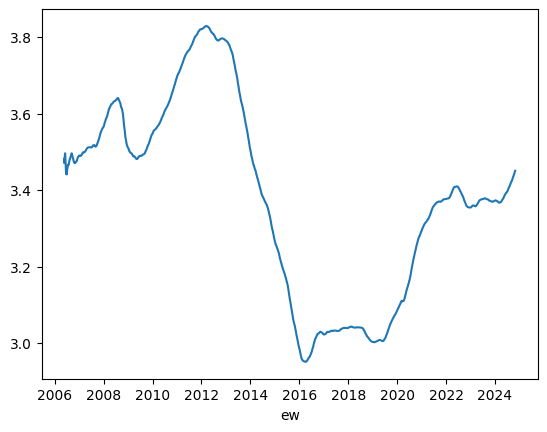

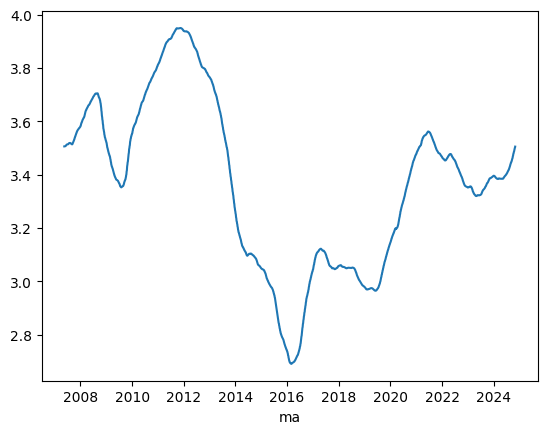

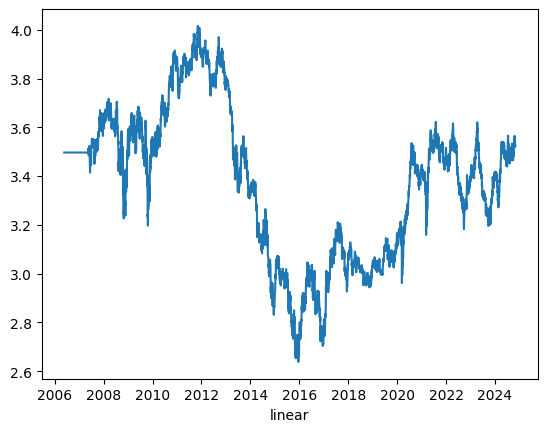

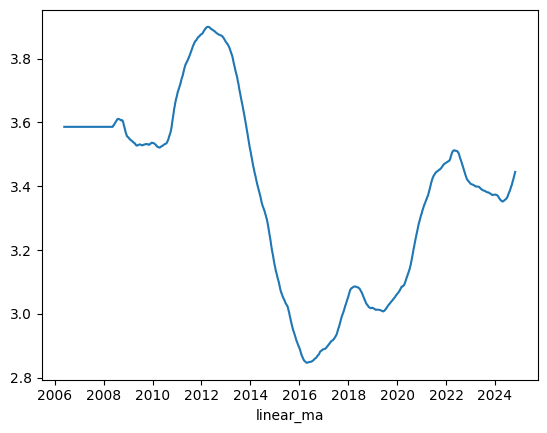

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(180.10371640358625,
 {'time_param': 246,
  'method': 'ew',
  't': 0.8681472285619017,
  'k': 5.374959265016483,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 0.9558598124593677
Round 1: 179.9981078856589
New best: 179.9981078856589
{'time_param': 246, 'method': 'ew', 't': 0.8681472285619017, 'k': 5.374959265016483, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


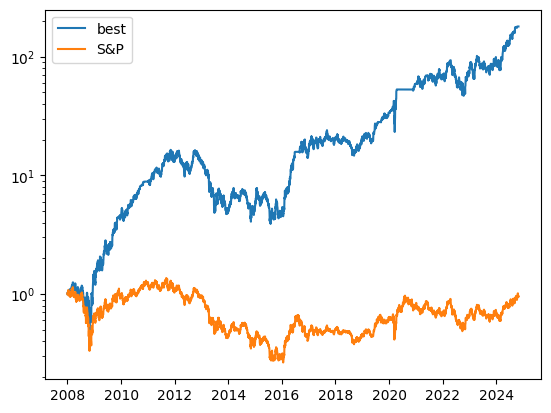

Round 2: 2.7408843530575235
Round 3: 54.122271267952534
Round 4: 11.48959114477005
Round 5: 15.444835423370758
Round 6: 39.595376027333536
Round 7: 61.19537603172115
Round 8: 28.585753232261922
Round 9: 53.39539136084859
Round 10: 6.690866164007498
Round 11: 32.320998283791525
Round 12: 10.693641589661297
Round 13: 12.008973932144519
Round 14: 63.074899849495786
Round 15: 16.682400747435437
Round 16: 39.9925504877649
Round 17: 11.306217017747993
Round 18: 62.104955557945694
Round 19: 36.878976481280226
Round 20: 18.37368112328745
Round 21: 1.5013147673352154
Round 22: 57.89587261611629
Round 23: 21.332393189431365
Round 24: 15.187864681591964
Round 25: 63.621322078316126
Round 26: 56.025425292861435
Round 27: 61.89471203410756
Round 28: 72.32032192483096
Round 29: 2.7682680553076797
Round 30: 22.692592336392455
Round 31: 31.752493567606624
Round 32: 31.94285727446525
Round 33: 60.98322963547152
Round 34: 22.469471336696582
Round 35: 3.621175376979749
Round 36: 29.249770223663234
Round 

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 0.9558598124593677
Round 1: 37.83610939987265
Round 2: 88.09917656858903
Round 3: 60.17100216886894
Round 4: 59.81036496293687
Round 5: 41.12227515427548
Round 6: 141.86956832510919
Round 7: 109.74495228708486
Round 8: 12.025600288885165
Round 9: 47.51136249571019
Round 10: 106.53813635000174

Factor: 1.03125
Do nothing res: 0.9558598124593677
Round 1: 37.97485724752535
Round 2: 62.17046885796338
Round 3: 59.77898240255913
Round 4: 45.40482165885852
Round 5: 59.79951307430518
Round 6: 59.77170687501369
Round 7: 59.79508390477856
Round 8: 59.78470963374207
Round 9: 177.69098776433634
Round 10: 132.7032696997363

Factor: 1.015625
Do nothing res: 0.9558598124593677
Round 1: 59.79709240914896
Round 2: 104.60330360564639
Round 3: 134.25567384560736
Round 4: 37.107551375002956
Round 5: 77.63730433421915
Round 6: 37.43947219264683
Round 7: 59.785704836275386
Round 8: 59.789435272605346
Round 9: 59.78014870678428
Round 10: 59.78384022961842

Factor: 1.0078125
Do 

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.005581261677778837

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.9362343817320121

In [24]:
params_out

{'time_param': 246,
 'method': 'ew',
 't': 0.8681472285619017,
 'k': 5.374959265016483,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


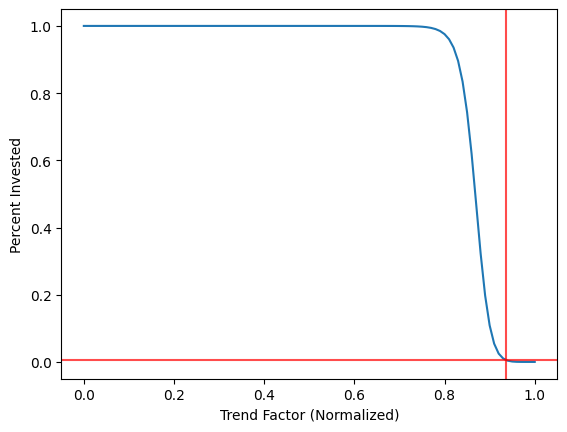

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

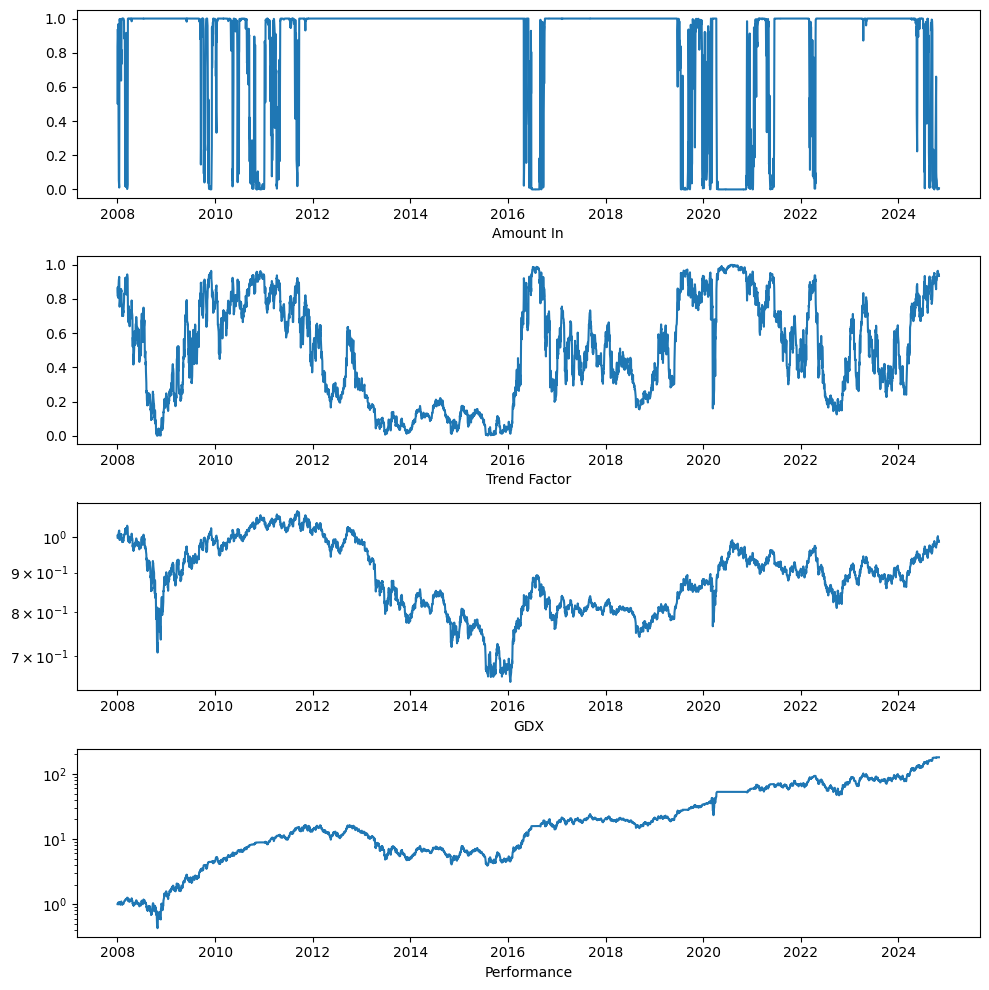

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

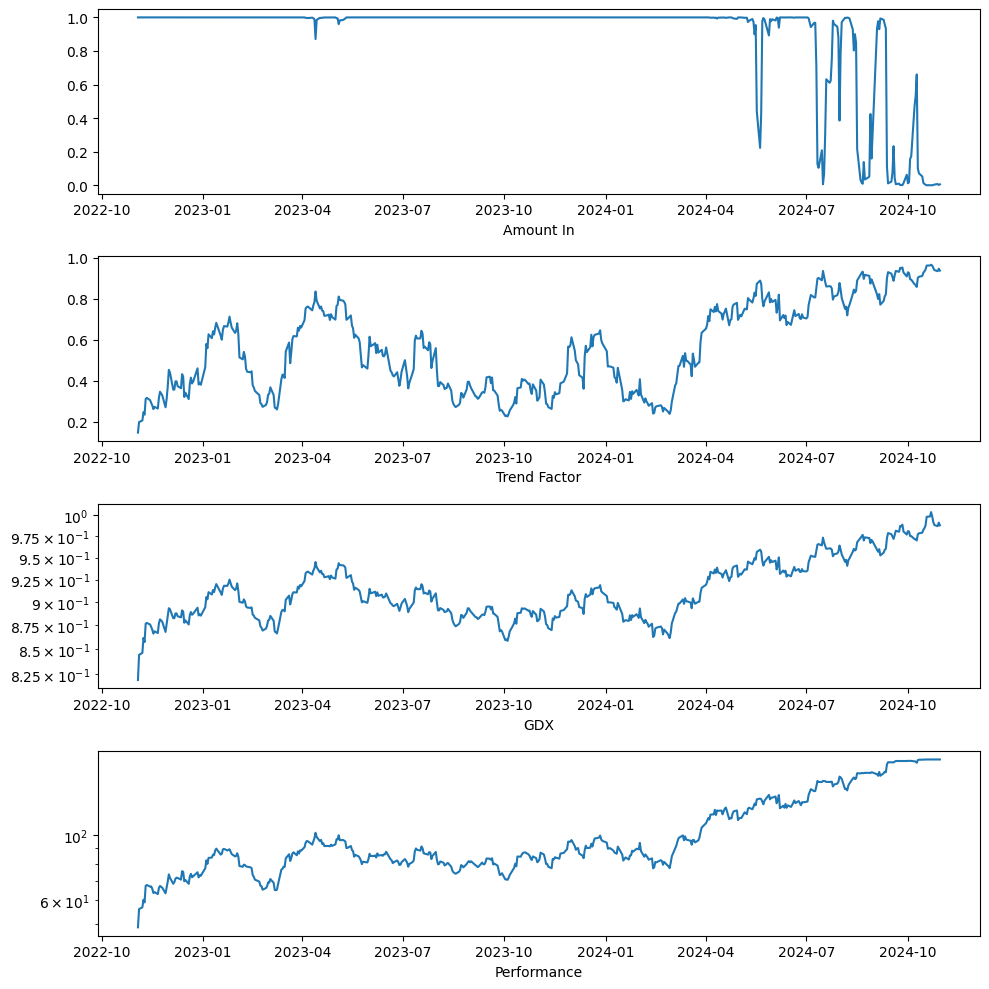

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.0056

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(43.4268684387207, 16.948, 41.5099983215332)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.3585319518059944

In [32]:
stop

NameError: name 'stop' is not defined

In [33]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(179.9981078856589,
 {'time_param': 246,
  'method': 'ew',
  't': 0.8681472285619017,
  'k': 5.374959265016483,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

In [34]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['gdx'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1202668911854718, 1.0], 'nas': [1.2412840054115306, 1.0], 'rus': [1.2929743800077413, 1.0], 'jpxn': [1.0743576183982226, 0.9816], 'ktec': [1.672814514216744, 0.0], 'emb': [1.0761592888276668, 1.0], 'gdx': [1.3585319518059944, 0.0056], 'dia': [1.2163458088040435, 1.0], 'nfty': [1.267319464372094, 1.0]}


In [35]:
# Normalized returns
keys = ['sp', 'nas', 'dia', 'rus', 'jpxn', 'ktec', 'emb', 'gdx', 'nfty']
rs = np.array([j[k][0] - 1 for k in keys])

# Manually reduce KTEC & GDX
#idx_ktec = keys.index('ktec')
#rs[idx_ktec] /= 1
#idx_gdx = keys.index('gdx')
#rs[idx_gdx] /= 1
#

rs = rs / rs.sum()
for k, r in zip(keys, rs):
    print(f'{k:4s}: {r:.4f}')

sp  : 0.0518
nas : 0.1040
dia : 0.0933
rus : 0.1263
jpxn: 0.0320
ktec: 0.2900
emb : 0.0328
gdx : 0.1545
nfty: 0.1152


In [36]:
# Fraction In
fracs_in = np.array([j[k][1]  for k in keys])
for k, f in zip(keys, fracs_in):
    print(f'{k:4s}: {f:.4f}')

sp  : 1.0000
nas : 1.0000
dia : 1.0000
rus : 1.0000
jpxn: 0.9816
ktec: 0.0000
emb : 1.0000
gdx : 0.0056
nfty: 1.0000


In [37]:
cash = 65       # Don't Forget Me!!!
#                   SPY,   ONEQ,  DIA,   IWF,   JPXN,  KTEC, EMB,   GDX, NFTY
current = np.array([20296, 40612, 36268, 49285, 12510, 0,    12804, 125, 39843])

val = current.sum() + cash
target = (val * rs * fracs_in).round()
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

sp  :   10980
nas :   22028
dia :   19751
rus :   26747
jpxn:    6664
ktec:       0
emb :    6953
gdx :     183
nfty:   24405


In [38]:
# normalize
target /= target.sum()
target *= val
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

sp  :   19757
nas :   39637
dia :   35540
rus :   48128
jpxn:   11991
ktec:       0
emb :   12511
gdx :     329
nfty:   43914


In [39]:
for k, diff in zip(keys, target - current):
    print(f'{k:4s}: {diff:7.0f}')

sp  :    -539
nas :    -975
dia :    -728
rus :   -1157
jpxn:    -519
ktec:       0
emb :    -293
gdx :     204
nfty:    4071
